In [1]:
import numpy as np
# %tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt

### Load the dataset.

In [2]:
# TensorFlow has some popular datasets already included. 
# Check out https://www.tensorflow.org/api_docs/python/tf/keras/datasets.
# In this homework we will work with the popular MNIST dataset.
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

### Investigate the dataset.

In [3]:
# You should make use of the following functions and properties.
# You can access the shape of an array 'arr' with 'arr.shape'.
# You can use 'np.max', 'np.min' to access the maximum or minimum of an array.
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)
print(np.max(train_images[0]))
print(np.min(train_images[0]))

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
255
0


**It is always important to understand the format and the count of the data you are dealing with.**  

*How many training/test images does this dataset have?*  
60000 training images, 10000 test images

*Which shape do the images have?*  
28 times 28 pixels

*In which range are the pixel values?*  
grey-scale from 0 to 255

### Visualize the dataset.

In [4]:
print(train_labels[:20])

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


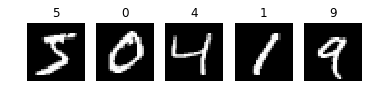

In [5]:
# It can also be helpful to have a proper look at specific samples of a dataset to understand what you are dealing with.
# Plot 5 samples with their corresponding label.

fig, ax = plt.subplots(1,5)
for i in range(5):

    # Readout an image and the corresponding label.
    img = train_images[i]
    lbl = train_labels[i]

    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(lbl)
    ax[i].axis("off")

### Build the TensorFlow dataset: Input pipeline

In [6]:
# tf.data.Dataset.from_tensor_slices creates a tf.dataset from a tensor. The elements of the dataset are slices of the first tensor dimension
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)
# the mapping function maps each  element to the dataset to the value defined by the lambda function
# reshapes each tensor to vector
train_dataset_images = train_dataset_images.map(lambda img : tf.cast(tf.expand_dims(img,-1), tf.float32))


train_dataset_targets = tf.data.Dataset.from_tensor_slices(train_labels)
# we want the labels to be onehot encoded
train_dataset_targets = train_dataset_targets.map(lambda t : tf.one_hot(t, 10))

# zip together input and labels
train_dataset = tf.data.Dataset.zip((train_dataset_images, train_dataset_targets))
train_dataset = train_dataset.batch(128)
train_dataset = train_dataset.shuffle(buffer_size=128)

# repeat for the test dataset
test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset_images = test_dataset_images.map(lambda img : tf.cast(tf.expand_dims(img, -1), tf.float32))

test_dataset_targets = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset_targets = test_dataset_targets.map(lambda t : tf.one_hot(t, 10))

test_dataset = tf.data.Dataset.zip((test_dataset_images, test_dataset_targets))
test_dataset = test_dataset.batch(128)
test_dataset = test_dataset.shuffle(buffer_size=128)


### Build the model.

In [7]:
for (img,_) in test_dataset:
    print(img.shape)
    break

(128, 28, 28, 1)


In [8]:

# We will implement a simple fully connected feed forward neural network like the last time.
#
# Our network will have the following layers:
# Input : 784 units.
# Hidden layer 1: 256 units. With sigmoid activation function.
# Hidden layer 2: 256 units. With sigmoid activation function.
# Output: 10 units. With softmax activation function.
# 
# Instead of implementing our own layer we can directly implement the network using pre-built layers 
# from TensorFlow.
# For that check out 'tf.keras.layers.Dense(units= , activation=)'. It is basically the same layer that we
# implemented by hand last time.
# For activations functions check out 'tf.keras.activations'.

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the three layers.
        self.conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                               input_shape=(28,28,1)
                                               )
        self.max_pool_1 = tf.keras.layers.MaxPool2D()
        self.conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                               )
        self.max_pool_2 = tf.keras.layers.MaxPool2D()

        self.conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                                )
        self.max_pool_3 = tf.keras.layers.MaxPool2D()

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()

        self.output_layer = tf.keras.layers.Dense(10,
                                                  activation=tf.keras.activations.softmax)


    def call(self, x):
        # Define the forward step.
        x = self.conv_1(x)
        x = self.max_pool_1(x)
        x = self.conv_2(x)
        x = self.max_pool_2(x)
        x = self.conv_3(x)
        x = self.max_pool_3(x)
        x = self.global_pool(x)
        x = self.output_layer(x)
        return x

### Train the model.

In [9]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy
  



In [10]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 3
learning_rate = 0.001
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)



Epoch: __ 0
Epoch: __ 1
Epoch: __ 2


### Visualize the training progress.

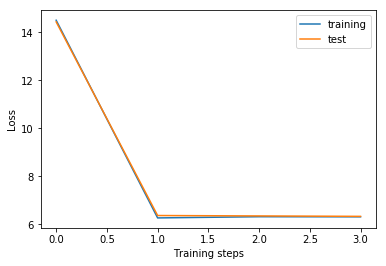

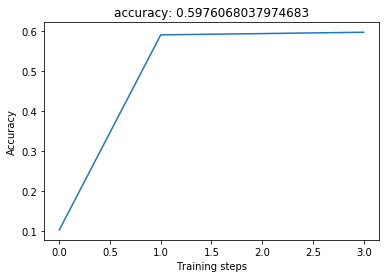

In [11]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.title('accuracy: '+ str(np.max(test_accuracies)))
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()


## Saving Model
Now that we have seen that our model performs pretty well, we might want to save all the parameters that it has learnt now and use it again later. For subclassed models you will need to use the function **save_weights()** and store it in a .h5 or .hdf5 format. 

In [12]:
model.save_weights('mnist_mlp.h5')

The next time we can load it again. You will first have to create the new model and call it, so it can create the variables, before you can insert weights into them.

In [13]:
new_model = model.load_weights('mnist_mlp.h5')